# Multivariate Linear Regression on DFT_SMC - All Data - With random yields

- Dataset: DFT_SMC, 90 of the ligands
- x = Multivariates, Selected Features
- y = Mismatched Yields from rxn II, Sam's paper             
Hypothesis: If the cross validation score is somewhat the same as the non-mismatched MLR prediction, that means MLR prediction fails to give out the most important features. Rather, the 'important' features were selected based on structure of the dataset. 

Data preparation

In [8]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem, MolFromSmiles
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import DataStructs
from rdkit import Chem
from rxnfp.tokenization import get_default_tokenizer, SmilesTokenizer
from rdkit.Chem import rdChemReactions

In [9]:
# data
import pandas as pd
from rdkit import Chem
#from rxn_yields.data import generate_buchwald_hartwig_rxns
#df = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx', sheet_name='FullCV_01')
df_origin = pd.read_excel('smc_data.xlsx', sheet_name='DFT_SMC')
df_origin = df_origin.sample(frac=1,random_state=42)
df_x = df_origin.drop(columns = ['SMILES','ID','ID.1','Unnamed: 0','y1','y2','y3','y4'])
df_x = df_x.drop(columns = ['y5','y6','y7','y8','y9','y10','y11','y12'])
df_x = df_x.drop(columns = ['y13','y14','y15','y16','y17','y18','y19','buch'])
df_x = df_x.drop(columns = ['x198','x199','x200','x201','x202','Unnamed: 110'])
df_y = df_origin[['x198']]
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Make it completely mismatched
df_y = df_y.sample(frac=1,random_state=41)

In [10]:
print('Shape of input:',df_x.shape,'\nShape of output:' ,df_y.shape)
df_x = df_x.astype(float)
df_y = df_y.astype(float)
df_x.to_excel("output.xlsx") 

Shape of input: (90, 198) 
Shape of output: (90, 1)


In [11]:
df_x

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x188,x189,x190,x191,x192,x193,x194,x195,x196,x197
40,-0.058034,1.819350,-0.233660,-0.028777,-0.131219,0.204883,0.042022,0.041558,-0.342908,0.788211,...,7.368250,0.563918,7.078067,36.0,40.0,12753.462690,196.1,184.2,31.6,30.1
22,-0.073437,1.807323,-0.206349,-0.028420,-0.117385,0.177929,0.038721,0.054666,-0.331972,0.785852,...,7.165718,0.094895,7.074700,11.0,15.0,1578.955194,244.1,189.9,67.8,43.9
55,-0.056110,1.784801,-0.228666,0.032498,-0.098084,0.261164,0.018421,0.113030,-0.459615,0.740428,...,7.728603,2.076087,7.639953,25.0,30.0,273.510250,178.4,156.9,39.5,31.1
70,-0.054117,1.820376,-0.213047,-0.027264,-0.120155,0.185783,0.038856,0.057774,-0.361696,0.774929,...,8.218253,1.613903,8.086322,21.0,25.0,1265.422722,199.5,165.8,45.9,30.9
0,-0.063670,1.784157,-0.206310,-0.023277,-0.114794,0.183033,0.036033,0.061658,-0.345264,0.816302,...,8.216943,1.308200,7.992698,22.0,28.0,2314.933917,209.9,168.9,60.5,32.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,-0.051811,1.840990,-0.223352,-0.026203,-0.124778,0.197149,0.039487,0.059468,-0.381121,0.796790,...,6.961257,0.056423,6.946171,4.0,11.0,279.968556,165.7,157.7,28.2,28.1
60,-0.065237,1.817551,-0.217569,-0.028678,-0.123123,0.188891,0.040127,0.062559,-0.375160,0.781223,...,7.291456,0.184814,7.291456,3.0,6.0,206.786250,211.7,174.9,55.9,36.9
71,-0.066524,1.791736,-0.206658,-0.012733,-0.109695,0.193925,0.031038,0.073707,-0.357585,0.798348,...,8.359458,1.325419,7.434323,32.0,37.0,2615.616833,216.5,165.3,56.9,31.6
14,-0.081156,1.834348,-0.189637,-0.008817,-0.099227,0.180820,0.027235,0.073212,-0.335489,0.879254,...,7.703383,1.044837,7.173690,7.0,12.0,848.823361,199.6,199.3,42.6,41.1


In [12]:
df_y

,x198
23,2.0
11,2.0
74,6.0
15,3.0
39,46.0
...,...
41,10.0
2,2.0
56,7.0
16,67.0


Permutation for 3 features

In [13]:
# permutations using library function !!not successful
from itertools import permutations 

perm = permutations(df_x.columns)
print(perm)

Visualization - three features

In [14]:
def plot_three_features(df_x,i,j,k):
    fig=plt.figure()
    ax=fig.add_subplot(111,projection='3d')
    n=100
    ax.scatter(df_x[i],df_x[j],df_x[k],color="red")
    ax.set_xlabel(i)
    ax.set_ylabel(j)
    ax.set_zlabel(k)
    print("A plot of axis:",i, j, ", and ",k)
    plt.show()

A plot of axis: x1 x2 , and  x3


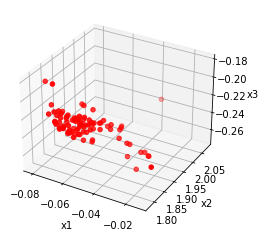

In [15]:
plot_three_features(df_x,'x1','x2','x3')

In [16]:
#This allows you to plot the 3d diagram of 2 features selected +1 feature from all features
for i in df_x.columns:
    #plot_three_features(df_x,i)
    continue

Splitting dataset

In [17]:
#Splitting dataset
train_x = df_x[:(int((len(df_x)*0.79)))]
train_y = df_y[:(int((len(df_x)*0.79)))]
test_x = df_x[(int((len(df_x)*0.79))):]
test_y = df_y[(int((len(df_x)*0.79))):]
print(train_x.shape)

(71, 198)


In [18]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
train_x1 = np.array(train_x[["x1"]])
train_x2 = np.array(train_x[["x2"]])
regr.fit(train_x,train_y)

LinearRegression()

# MLR - with all features

In [19]:
#Not using this package
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(df_x)

In [20]:
def linear_reg_of_n_features(df_x,df_y):
    reg=linear_model.LinearRegression()     #initiating linearregression
    model = reg.fit(df_x,df_y)
    Intercept=reg.intercept_
    Coefficients=reg.coef_
    return Intercept, Coefficients, model
    

In [21]:
Intercept, Coefficients, model = linear_reg_of_n_features(train_x,train_y)

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

reg_predictions = model.predict(train_x)
reg_mse = mean_squared_error(train_y, reg_predictions)
reg_rmse = np.sqrt(reg_mse)
print("Training set RMSE:",reg_rmse)

reg_predictions2 = model.predict(test_x)
reg_mse2 = mean_squared_error(test_y, reg_predictions2)
reg_rmse2 = np.sqrt(reg_mse2)
print("Test set RMSE:",reg_rmse2)

r2_score2=r2_score(train_y, reg_predictions)
print("Training set R^2:",r2_score2)
r2_score3=r2_score(test_y, reg_predictions2)
print("Test set R^2:",r2_score3)

Training set RMSE: 9.159765726822187e-13
Test set RMSE: 90.41481218067449
Training set R^2: 1.0
Test set R^2: -11.428789398933882


In [23]:
print("Intercept:",Intercept,"Coefficient:",Coefficients)

Intercept: [-574.00397359] Coefficient: [[ 1.73305050e-02  9.25305538e-02 -2.07827381e-01 -8.56220053e-02
  -1.46724690e-01  1.22205376e-01  8.48988537e-03  1.11712587e-01
   9.43648249e-03  3.49891612e-01  2.62731047e-01 -6.34540071e-02
   1.74834162e+00  1.85623684e+00  1.15998790e-02  9.47234811e-01
   3.93828786e-01 -1.30567359e+00 -1.04342826e-01 -3.50073821e-02
   1.11847701e-01 -7.68422732e-02  5.90023442e-02 -7.48650881e+00
   1.03604970e+01  3.44681331e-02 -7.82977732e-02 -2.00146216e-01
  -4.72199400e-02  1.15415639e-01 -1.10807487e-01  7.74802346e-02
   1.39639009e-02 -5.79901529e-02 -1.00006799e-02  2.75045542e-01
   7.76155444e+00  2.28416711e-01  1.51835951e-02  8.71605514e-02
   1.39845001e+00 -1.93501683e+00  5.32536110e-02  3.12211967e+00
  -1.10681449e+00 -2.93651482e+00 -8.20083997e+00 -7.27219811e-01
   8.83608767e-01  1.43522488e-01  1.03246138e+01 -2.32878915e+00
   5.95918542e+00  8.28797459e+00 -1.37815304e+00 -4.53017531e+00
   4.31271247e+00  6.91803851e+00  2

# MLR - with 3 features

In [24]:
def linear_reg_of_3_features(df_x,df_y,i,j,k):
    df_3f = df_x[[i,j,k]]
    reg=linear_model.LinearRegression()     #initiating linearregression
    model = reg.fit(df_3f,df_y)
    Intercept=reg.intercept_
    Coefficients=reg.coef_
    return Intercept, Coefficients, model
    

In [25]:
def evaluate_model_of_3_features(train_x,train_y,test_x,test_y,model,i,j,k):
    reg_predictions = model.predict(train_x[[i,j,k]])
    train_mse = mean_squared_error(train_y, reg_predictions)
    train_rmse = "{:.2f}".format(np.sqrt(train_mse))

    reg_predictions2 = model.predict(test_x[[i,j,k]])
    test_mse = mean_squared_error(test_y, reg_predictions2)
    test_rmse = "{:.2f}".format(np.sqrt(test_mse))

    train_r2="{:.2f}".format(r2_score(train_y, reg_predictions))
    test_r2="{:.2f}".format(r2_score(test_y, reg_predictions2))
    return train_rmse, test_rmse, train_r2, test_r2

In [26]:
def evaluate_model_of_n_features(train_x,train_y,test_x,test_y,model):
    reg_predictions = model.predict(train_x)
    train_mse = mean_squared_error(train_y, reg_predictions)
    train_rmse = "{:.2f}".format(np.sqrt(train_mse))

    reg_predictions2 = model.predict(test_x)
    test_mse = mean_squared_error(test_y, reg_predictions2)
    test_rmse = "{:.2f}".format(np.sqrt(test_mse))

    train_r2="{:.2f}".format(r2_score(train_y, reg_predictions))
    test_r2="{:.2f}".format(r2_score(test_y, reg_predictions2))
    return train_rmse, test_rmse, train_r2, test_r2

In [27]:
#Combination of all columns from dataframe
def all_features(df):
    all_features = df.columns.values.tolist()
    return all_features

In [28]:
#This code actually generate a real combination of 3 features, but it just... contains too many for loops
all_feat = all_features(df_x)
def combination_any_3_features(all_feat):
    comb_3_feat = []
    for i in all_feat:
        for j in all_feat:
            for k in all_feat:
                if i!=j and j!=k and k!=i:
                    comb_3_feat.append([i,j,k])
        
    return comb_3_feat

In [29]:
def combination_any_2_features(all_feat,preset_feat):
    comb_2_feat = []
    for i in all_feat:
        for j in all_feat:
            if i!=j and i!=preset_feat and j!=preset_feat:
                comb_2_feat.append([preset_feat,i,j])
        
    return comb_2_feat

In [30]:
feats = combination_any_2_features(df_x,'x30')

In [31]:
all_feat.index('x1')

0

Do not re-do the feature combination generation because it cost time

In [32]:
#x1x2x3 x2x3x4 x3x4x5... a 'combination' that has 190~ elements so that I try things that aren't computational demanding
def fake_combination_any_3_features(df):
    comb_3_feat = []
    k="x1"
    for i in df.columns:
        while k != 'x197':
            j = df.columns[df.columns.get_loc(i)+1]
            k = df.columns[df.columns.get_loc(j)+1]
            if i !=j and j!=k and i!=k:
                print(i,j,k)
                comb_3_feat.append([i,j,k])
                i = df.columns[df.columns.get_loc(i)+1]
    return comb_3_feat

        

In [33]:
#df_x_set = combination_any_3_features(df_x)
#Run time: 24s

In [34]:
#Write down combination of any 3 features into a txt
#Txt already generated
"""
with open(r'all_features.txt', 'w') as fp:
    for item in df_x_set:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
"""

'\nwith open(r\'all_features.txt\', \'w\') as fp:\n    for item in df_x_set:\n        # write each item on a new line\n        fp.write("%s\n" % item)\n    print(\'Done\')\n'

In [35]:
#Early attemps - trying to use mlr from math formular
"""
def hypothesis(theta, X):
    return theta*X
def computeCost(X, y, theta):
    y1 = hypothesis(theta, X)
    y1=np.sum(y1, axis=1)
    return sum(np.sqrt((y1-y)**2))/(2*47)
def gradientDescent(X, y, theta, alpha, i):
    J = []  #cost function in each iterations
    k = 0
    while k < i:        
        y1 = hypothesis(theta, X)
        y1 = np.sum(y1, axis=1)
        for c in range(0, len(X.columns)):
            print(theta[c])
            theta[c] = theta[c] - alpha*(((y1.sum()-y.sum())*X.iloc[:,c])/len(X))
        j = computeCost(X, y, theta)
        J.append(j)
        k += 1
    return J, j, theta
"""

'\ndef hypothesis(theta, X):\n    return theta*X\ndef computeCost(X, y, theta):\n    y1 = hypothesis(theta, X)\n    y1=np.sum(y1, axis=1)\n    return sum(np.sqrt((y1-y)**2))/(2*47)\ndef gradientDescent(X, y, theta, alpha, i):\n    J = []  #cost function in each iterations\n    k = 0\n    while k < i:        \n        y1 = hypothesis(theta, X)\n        y1 = np.sum(y1, axis=1)\n        for c in range(0, len(X.columns)):\n            print(theta[c])\n            theta[c] = theta[c] - alpha*(((y1.sum()-y.sum())*X.iloc[:,c])/len(X))\n        j = computeCost(X, y, theta)\n        J.append(j)\n        k += 1\n    return J, j, theta\n'

# Screening over 3 features - 1 fixed + combination with 2

Features Combination - feats, a list, len(list) lines, each line with n number of features

In [36]:
# 1 pre-determined feature + all combination of 2 features = 3 features total
# df_x and train_x are both okay here... because the columns are the same
feats = combination_any_2_features(df_x,'x30')

In [37]:
# Numbers of combinations (197*196)
len(feats)

38612

In [38]:
print('----------Linear regression of 3 features starts----------')
List_r2_4 = []
List_r2_3 = []
List_r2_2 = []
for m in feats:
    i = feats.index(m)
    Intercept, Coefficient, model = linear_reg_of_3_features(train_x,train_y,feats[i][0],feats[i][1],feats[i][2])
    #print('For features',feats[i][0],feats[i][1],feats[i][2],': Intercept:',Intercept,', Coefficient: ',Coefficient)
    train_rmse, test_rmse, train_r2,test_r2 = evaluate_model_of_3_features(train_x,train_y,test_x,test_y,model,feats[i][0],feats[i][1],feats[i][2])
    #print('Training rmse:',train_rmse, '\nTest rmse: ',test_rmse, '\nTraining r2:',train_r2, '\nTest r2: ',test_r2 )
    if float(test_r2) >=0.4: 
        print('Significant!')
        print('For features',feats[i][0],feats[i][1],feats[i][2],': Intercept:',Intercept,', Coefficient: ',Coefficient)
        print('Training rmse:',train_rmse, '\nTest rmse: ',test_rmse, '\nTraining r2:',train_r2, '\nTest r2: ',test_r2 )
        List_r2_4.append([feats[i][0],feats[i][1],feats[i][2]])
    elif float(test_r2) >=0.3:
        List_r2_3.append([feats[i][0],feats[i][1],feats[i][2]])
        

----------Linear regression of 3 features starts----------
Significant!
For features x30 x12 x121 : Intercept: [11.24120134] , Coefficient:  [[37.4100831  13.7324869  65.73584174]]
Training rmse: 24.51 
Test rmse:  19.91 
Training r2: 0.02 
Test r2:  0.40
Significant!
For features x30 x15 x121 : Intercept: [-7.52146975] , Coefficient:  [[-0.36427944  0.09116967 59.22541568]]
Training rmse: 24.45 
Test rmse:  19.22 
Training r2: 0.03 
Test r2:  0.44
Significant!
For features x30 x16 x121 : Intercept: [-12.88274779] , Coefficient:  [[-94.8337953    0.19432773  36.0476232 ]]
Training rmse: 24.02 
Test rmse:  19.94 
Training r2: 0.06 
Test r2:  0.40
Significant!
For features x30 x20 x121 : Intercept: [61.51724151] , Coefficient:  [[-4.90838919 52.21814056 56.81567841]]
Training rmse: 24.24 
Test rmse:  19.39 
Training r2: 0.04 
Test r2:  0.43
Significant!
For features x30 x21 x121 : Intercept: [-27.20854232] , Coefficient:  [[-12.95100326 -75.94609058  55.39837664]]
Training rmse: 24.13 
T

In [39]:
List_r2_4

[['x30', 'x12', 'x121'],
 ['x30', 'x15', 'x121'],
 ['x30', 'x16', 'x121'],
 ['x30', 'x20', 'x121'],
 ['x30', 'x21', 'x121'],
 ['x30', 'x24', 'x121'],
 ['x30', 'x40', 'x121'],
 ['x30', 'x42', 'x121'],
 ['x30', 'x48', 'x121'],
 ['x30', 'x49', 'x121'],
 ['x30', 'x106', 'x121'],
 ['x30', 'x108', 'x121'],
 ['x30', 'x109', 'x121'],
 ['x30', 'x110', 'x121'],
 ['x30', 'x116', 'x121'],
 ['x30', 'x117', 'x121'],
 ['x30', 'x118', 'x121'],
 ['x30', 'x119', 'x121'],
 ['x30', 'x120', 'x121'],
 ['x30', 'x121', 'x12'],
 ['x30', 'x121', 'x15'],
 ['x30', 'x121', 'x16'],
 ['x30', 'x121', 'x20'],
 ['x30', 'x121', 'x21'],
 ['x30', 'x121', 'x24'],
 ['x30', 'x121', 'x40'],
 ['x30', 'x121', 'x42'],
 ['x30', 'x121', 'x48'],
 ['x30', 'x121', 'x49'],
 ['x30', 'x121', 'x106'],
 ['x30', 'x121', 'x108'],
 ['x30', 'x121', 'x109'],
 ['x30', 'x121', 'x110'],
 ['x30', 'x121', 'x116'],
 ['x30', 'x121', 'x117'],
 ['x30', 'x121', 'x118'],
 ['x30', 'x121', 'x119'],
 ['x30', 'x121', 'x120'],
 ['x30', 'x121', 'x136'],
 ['x30

In [40]:
#To test with fake combination of 3 features
feats = fake_combination_any_3_features(df_x)

x1 x2 x3
x2 x3 x4
x3 x4 x5
x4 x5 x6
x5 x6 x7
x6 x7 x8
x7 x8 x9
x8 x9 x10
x9 x10 x11
x10 x11 x12
x11 x12 x13
x12 x13 x14
x13 x14 x15
x14 x15 x16
x15 x16 x17
x16 x17 x18
x17 x18 x19
x18 x19 x20
x19 x20 x21
x20 x21 x22
x21 x22 x23
x22 x23 x24
x23 x24 x25
x24 x25 x26
x25 x26 x27
x26 x27 x28
x27 x28 x29
x28 x29 x30
x29 x30 x31
x30 x31 x32
x31 x32 x33
x32 x33 x34
x33 x34 x35
x34 x35 x36
x35 x36 x37
x36 x37 x38
x37 x38 x39
x38 x39 x40
x39 x40 x41
x40 x41 x42
x41 x42 x43
x42 x43 x44
x43 x44 x45
x44 x45 x46
x45 x46 x47
x46 x47 x48
x47 x48 x49
x48 x49 x50
x49 x50 x51
x50 x51 x52
x51 x52 x53
x52 x53 x54
x53 x54 x55
x54 x55 x56
x55 x56 x57
x56 x57 x58
x57 x58 x59
x58 x59 x60
x59 x60 x61
x60 x61 x62
x61 x62 x63
x62 x63 x64
x63 x64 x65
x64 x65 x66
x65 x66 x67
x66 x67 x68
x67 x68 x69
x68 x69 x70
x69 x70 x71
x70 x71 x72
x71 x72 x73
x72 x73 x74
x73 x74 x75
x74 x75 x76
x75 x76 x77
x76 x77 x78
x77 x78 x79
x78 x79 x80
x79 x80 x81
x80 x81 x82
x81 x82 x83
x82 x83 x84
x83 x84 x85
x84 x85 179.59438003021648
x

In [41]:
print('----------Linear regression of 3 features starts----------')
List_r2_4 = []
List_r2_3 = []
List_r2_2 = []
for m in feats:
    i = feats.index(m)
    Intercept, Coefficient, model = linear_reg_of_3_features(train_x,train_y,feats[i][0],feats[i][1],feats[i][2])
    #print('For features',feats[i][0],feats[i][1],feats[i][2],': Intercept:',Intercept,', Coefficient: ',Coefficient)
    train_rmse, test_rmse, train_r2,test_r2 = evaluate_model_of_3_features(train_x,train_y,test_x,test_y,model,feats[i][0],feats[i][1],feats[i][2])
    #print('Training rmse:',train_rmse, '\nTest rmse: ',test_rmse, '\nTraining r2:',train_r2, '\nTest r2: ',test_r2 )
    if float(test_r2) >=0.2: 
        print('Significant!')
        print('For features',feats[i][0],feats[i][1],feats[i][2],': Intercept:',Intercept,', Coefficient: ',Coefficient)
        print('Training rmse:',train_rmse, '\nTest rmse: ',test_rmse, '\nTraining r2:',train_r2, '\nTest r2: ',test_r2 )
        List_r2_2.append([feats[i][0],feats[i][1],feats[i][2]])
    elif float(test_r2) >=0.3:
        List_r2_3.append([feats[i][0],feats[i][1],feats[i][2]])

----------Linear regression of 3 features starts----------
Significant!
For features x13 x14 x15 : Intercept: [-159.02134553] , Coefficient:  [[124.66529356 -65.92034753   0.22617462]]
Training rmse: 24.12 
Test rmse:  22.92 
Training r2: 0.05 
Test r2:  0.20
Significant!
For features x63 x64 x65 : Intercept: [24.38225126] , Coefficient:  [[-5.54025137  3.52721836  4.05049439]]
Training rmse: 23.60 
Test rmse:  22.48 
Training r2: 0.09 
Test r2:  0.23
Significant!
For features x119 x120 x121 : Intercept: [24.74829252] , Coefficient:  [[-2.63885808e-02 -5.07614992e-02  6.80179397e+01]]
Training rmse: 24.08 
Test rmse:  19.55 
Training r2: 0.06 
Test r2:  0.42
Significant!
For features x120 x121 x122 : Intercept: [24.53890102] , Coefficient:  [[-5.99770403e-02  6.54338819e+01  0.00000000e+00]]
Training rmse: 24.10 
Test rmse:  19.92 
Training r2: 0.05 
Test r2:  0.40


In [42]:
List_r2_3

[]

In [43]:
def combination_of_features_doing_MLR(feats,train_x,train_y,test_x,test_y):
    print('----------Linear regression of 3 features starts----------')
    List_r2_4 = []
    List_r2_3 = []
    #List_r2_2 = []
    for m in feats:
        i = feats.index(m)
        Intercept, Coefficient, model = linear_reg_of_3_features(train_x,train_y,feats[i][0],feats[i][1],feats[i][2])
        #print('For features',feats[i][0],feats[i][1],feats[i][2],': Intercept:',Intercept,', Coefficient: ',Coefficient)
        train_rmse, test_rmse, train_r2,test_r2 = evaluate_model_of_3_features(train_x,train_y,test_x,test_y,model,feats[i][0],feats[i][1],feats[i][2])
        #print('Training rmse:',train_rmse, '\nTest rmse: ',test_rmse, '\nTraining r2:',train_r2, '\nTest r2: ',test_r2 )
        if float(test_r2) >=0.4: 
            print('Significant!')
            print('For features',feats[i][0],feats[i][1],feats[i][2],': Intercept:',Intercept,', Coefficient: ',Coefficient)
            print('Training rmse:',train_rmse, '\nTest rmse: ',test_rmse, '\nTraining r2:',train_r2, '\nTest r2: ',test_r2 )
            List_r2_4.append([feats[i][0],feats[i][1],feats[i][2]])
        elif float(test_r2) >=0.3:
            List_r2_3.append([feats[i][0],feats[i][1],feats[i][2]])
    return List_r2_4,List_r2_3

Screening of some features that are significant from fake combination of 3 features

In [44]:
# Don't use df_x and df_y, they are not splitted. Use train_x and etc
feats = combination_any_2_features(df_x,'x49')
List_r2_4_x49,List_r2_3_x49 = combination_of_features_doing_MLR(feats,train_x,train_y,test_x,test_y)


----------Linear regression of 3 features starts----------
Significant!
For features x49 x1 x121 : Intercept: [42.14091129] , Coefficient:  [[-2.04083445e-02  2.62470551e+02  6.20859228e+01]]
Training rmse: 24.12 
Test rmse:  19.67 
Training r2: 0.05 
Test r2:  0.41
Significant!
For features x49 x2 x121 : Intercept: [-121.86565632] , Coefficient:  [[-2.46598929e-02  8.27607035e+01  6.81899033e+01]]
Training rmse: 24.02 
Test rmse:  19.82 
Training r2: 0.06 
Test r2:  0.40
Significant!
For features x49 x15 x121 : Intercept: [3.287756] , Coefficient:  [[-2.00229324e-02  8.28292634e-02  5.69516584e+01]]
Training rmse: 24.26 
Test rmse:  18.75 
Training r2: 0.04 
Test r2:  0.47
Significant!
For features x49 x16 x121 : Intercept: [-17.49281811] , Coefficient:  [[-2.02404173e-02  1.72524978e-01  3.36073472e+01]]
Training rmse: 23.85 
Test rmse:  19.52 
Training r2: 0.07 
Test r2:  0.42
Significant!
For features x49 x20 x121 : Intercept: [59.14045843] , Coefficient:  [[-1.48415021e-02  4.2559

KeyboardInterrupt: 

In [45]:
feats = combination_any_2_features(df_x,'x121')
List_r2_4_x121,List_r2_3_x121 = combination_of_features_doing_MLR(feats,train_x,train_y,test_x,test_y)

----------Linear regression of 3 features starts----------
Significant!
For features x121 x1 x4 : Intercept: [38.70711863] , Coefficient:  [[ 58.45910518 335.31365194  51.06912861]]
Training rmse: 24.29 
Test rmse:  19.93 
Training r2: 0.04 
Test r2:  0.40
Significant!
For features x121 x1 x5 : Intercept: [44.98277481] , Coefficient:  [[ 60.86837394 333.76860001  60.71197155]]
Training rmse: 24.31 
Test rmse:  19.90 
Training r2: 0.04 
Test r2:  0.40
Significant!
For features x121 x1 x8 : Intercept: [33.70035327] , Coefficient:  [[ 58.96971227 332.39389109  58.45283393]]
Training rmse: 24.27 
Test rmse:  19.84 
Training r2: 0.04 
Test r2:  0.40
Significant!
For features x121 x1 x15 : Intercept: [21.07856731] , Coefficient:  [[6.06808853e+01 2.39926057e+02 3.82588607e-02]]
Training rmse: 24.31 
Test rmse:  19.57 
Training r2: 0.04 
Test r2:  0.42
Significant!
For features x121 x1 x16 : Intercept: [-17.08591216] , Coefficient:  [[38.35377727 83.65855938  0.15591643]]
Training rmse: 24.04

In [47]:
def combination_of_features_doing_MLR_7(feats,train_x,train_y,test_x,test_y):
    print('----------Linear regression of 3 features starts----------')
    List_r2_7 = []
    List_r2_6 = []
    #List_r2_2 = []
    for m in feats:
        i = feats.index(m)
        Intercept, Coefficient, model = linear_reg_of_3_features(train_x,train_y,feats[i][0],feats[i][1],feats[i][2])
        #print('For features',feats[i][0],feats[i][1],feats[i][2],': Intercept:',Intercept,', Coefficient: ',Coefficient)
        train_rmse, test_rmse, train_r2,test_r2 = evaluate_model_of_3_features(train_x,train_y,test_x,test_y,model,feats[i][0],feats[i][1],feats[i][2])
        #print('Training rmse:',train_rmse, '\nTest rmse: ',test_rmse, '\nTraining r2:',train_r2, '\nTest r2: ',test_r2 )
        if float(test_r2) >=0.7: 
            print('Significant!')
            print('For features',feats[i][0],feats[i][1],feats[i][2],': Intercept:',Intercept,', Coefficient: ',Coefficient)
            print('Training rmse:',train_rmse, '\nTest rmse: ',test_rmse, '\nTraining r2:',train_r2, '\nTest r2: ',test_r2 )
            List_r2_7.append([feats[i][0],feats[i][1],feats[i][2]])
        elif float(test_r2) >=0.6:
            List_r2_6.append([feats[i][0],feats[i][1],feats[i][2]])
    return List_r2_7,List_r2_6

In [46]:
List_r2_4_x121

[['x121', 'x1', 'x4'],
 ['x121', 'x1', 'x5'],
 ['x121', 'x1', 'x8'],
 ['x121', 'x1', 'x15'],
 ['x121', 'x1', 'x16'],
 ['x121', 'x1', 'x20'],
 ['x121', 'x1', 'x21'],
 ['x121', 'x1', 'x24'],
 ['x121', 'x1', 'x36'],
 ['x121', 'x1', 'x39'],
 ['x121', 'x1', 'x40'],
 ['x121', 'x1', 'x42'],
 ['x121', 'x1', 'x43'],
 ['x121', 'x1', 'x48'],
 ['x121', 'x1', 'x49'],
 ['x121', 'x1', 'x50'],
 ['x121', 'x1', 'x68'],
 ['x121', 'x1', 'x106'],
 ['x121', 'x1', 'x107'],
 ['x121', 'x1', 'x108'],
 ['x121', 'x1', 'x109'],
 ['x121', 'x1', 'x110'],
 ['x121', 'x1', 'x116'],
 ['x121', 'x1', 'x117'],
 ['x121', 'x1', 'x118'],
 ['x121', 'x1', 'x119'],
 ['x121', 'x1', 'x120'],
 ['x121', 'x1', 'x136'],
 ['x121', 'x1', 'x137'],
 ['x121', 'x1', 'x138'],
 ['x121', 'x1', 'x139'],
 ['x121', 'x1', 'x140'],
 ['x121', 'x1', 'x151'],
 ['x121', 'x1', 'x153'],
 ['x121', 'x1', 'x154'],
 ['x121', 'x1', 'x155'],
 ['x121', 'x1', 'x158'],
 ['x121', 'x1', 'x159'],
 ['x121', 'x1', 'x166'],
 ['x121', 'x1', 'x168'],
 ['x121', 'x1', 'x16

In [48]:
feats = combination_any_2_features(df_x,'x121')
List_r2_7_x121,List_r2_6_x121 = combination_of_features_doing_MLR_7(feats,train_x,train_y,test_x,test_y)

----------Linear regression of 3 features starts----------


In [49]:
List_r2_6_x121

[['x121', 'x15', 'x109'], ['x121', 'x109', 'x15']]

In [61]:
feats = combination_any_2_features(df_x,'x109')
List_r2_7_x109,List_r2_6_x109 = combination_of_features_doing_MLR_7(feats,train_x,train_y,test_x,test_y)

----------Linear regression of 3 features starts----------


In [62]:
List_r2_6_x109

[['x109', 'x15', 'x121'], ['x109', 'x121', 'x15']]

In [64]:
feats = combination_any_2_features(df_x,'x15')
List_r2_7_x15,List_r2_6_x15 = combination_of_features_doing_MLR_7(feats,train_x,train_y,test_x,test_y)

----------Linear regression of 3 features starts----------


In [65]:
List_r2_6_x15

[['x15', 'x109', 'x121'], ['x15', 'x121', 'x109']]

# Evaluation and Cross validation with any selection of features

In [53]:
from sklearn.model_selection import cross_val_score


In [54]:
# This program auto - split the data, so safe to use df_x and df_y as input. 
# Make sure to cut df_x beforehand into a df with chosen amount of features.
def fold_5_cross_validation(df_x,df_y):
    train_x = df_x[:(int((len(df_x)*0.79)))]
    train_y = df_y[:(int((len(df_x)*0.79)))]
    test_x = df_x[(int((len(df_x)*0.79))):]
    test_y = df_y[(int((len(df_x)*0.79))):]
    Intercept, Coefficients, regg = linear_reg_of_n_features(train_x,train_y)
    print('Intercept:',Intercept,', Coefficient: ',Coefficients)
    train_rmse, test_rmse, train_r2,test_r2 = evaluate_model_of_n_features(train_x,train_y,test_x,test_y,regg)
    print('Training set RMSE:',train_rmse, '\nTest set RMSE: ',test_rmse, '\nTraining set R^2:',train_r2, '\nTest set R^2: ',test_r2 )
    cvd_scores = cross_val_score(regg, df_x, df_y, cv=5)
    print('5 fold Cross Validation score: ',cvd_scores)

In [66]:
df_3f = df_x[['x121', 'x109', 'x15']]
fold_5_cross_validation(df_3f,df_y)

Intercept: [-7.57923915] , Coefficient:  [[49.02079966 -0.17280165  0.10057377]]
Training set RMSE: 23.46 
Test set RMSE:  19.06 
Training set R^2: 0.14 
Test set R^2:  0.32
5 fold Cross Validation score:  [ 0.05827843 -1.16526978 -0.39661085  0.08066675  0.24105172]


A plot of axis: x121 x109 , and  x15


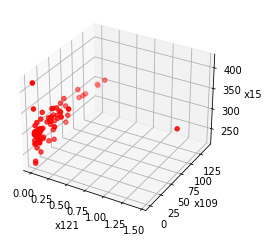

In [67]:
plot_three_features(df_x,'x121', 'x109', 'x15')

In [68]:
df_4f = df_x[['x121', 'x109', 'x15','x1']]
fold_5_cross_validation(df_4f,df_y)

Intercept: [10.20530211] , Coefficient:  [[ 4.91078568e+01 -1.65766967e-01  7.00439666e-02  1.62093717e+02]]
Training set RMSE: 23.39 
Test set RMSE:  19.29 
Training set R^2: 0.15 
Test set R^2:  0.30
5 fold Cross Validation score:  [ 0.06314402 -1.13734216 -0.48396012 -0.09849651  0.25157431]


Best combination of features in Sigman's code: x180, x24, x25, x29, x40, x57, x70

In [69]:
df_7f = df_x[['x24','x180','x25','x29','x40','x57','x70']]
fold_5_cross_validation(df_7f,df_y)

Intercept: [-179.47925193] , Coefficient:  [[ 2.11424855 13.87104202  3.46548544 44.54736187 43.15414508  0.41201987
  -1.05351883]]
Training set RMSE: 23.42 
Test set RMSE:  23.87 
Training set R^2: 0.15 
Test set R^2:  -0.07
5 fold Cross Validation score:  [ 0.16394432  0.05192853 -1.25052277 -0.03222265 -0.24252682]


regularization, l1l2 right - havn't done

# Streamline Cross Validation

In [70]:
def fold_5_cross_validation_for_stream(df_x,df_y):
    train_x = df_x[:(int((len(df_x)*0.79)))]
    train_y = df_y[:(int((len(df_x)*0.79)))]
    test_x = df_x[(int((len(df_x)*0.79))):]
    test_y = df_y[(int((len(df_x)*0.79))):]
    Intercept, Coefficients, regg = linear_reg_of_n_features(train_x,train_y)
    #print('Intercept:',Intercept,', Coefficient: ',Coefficients)
    train_rmse, test_rmse, train_r2,test_r2 = evaluate_model_of_n_features(train_x,train_y,test_x,test_y,regg)
    #print('Training set RMSE:',train_rmse, '\nTest set RMSE: ',test_rmse, '\nTraining set R^2:',train_r2, '\nTest set R^2: ',test_r2 )
    cvd_scores = cross_val_score(regg, df_x, df_y, cv=5)
    sum_cvd = sum(cvd_scores)
    print('5 fold Cross Validation score: ',sum_cvd)
    return sum_cvd

In [71]:
comb1=0
comb2 =0
comb3=0
for i in range(1,90):
    df_x=df_x.sample(frac=1,random_state=i)
    df_y = df_y.sample(frac=1,random_state = i)
    df_3f = df_x[['x4','x121','x5']]
    comb1 += fold_5_cross_validation_for_stream(df_3f,df_y)
    df_3f = df_x[['x121', 'x109', 'x15']]
    comb2 += fold_5_cross_validation_for_stream(df_3f,df_y)
    df_7f = df_x[['x24','x180','x25','x29','x40','x57','x70']]
    comb3 += fold_5_cross_validation_for_stream(df_7f,df_y)

5 fold Cross Validation score:  -5.3210881342293295
5 fold Cross Validation score:  -2.24670668672148
5 fold Cross Validation score:  -1.2009577509395768
5 fold Cross Validation score:  -0.3052220887849838
5 fold Cross Validation score:  0.5362017849742503
5 fold Cross Validation score:  -0.4371436449327357
5 fold Cross Validation score:  -0.5300760758809153
5 fold Cross Validation score:  0.43871187695293
5 fold Cross Validation score:  -0.2806764264730751
5 fold Cross Validation score:  -0.4474941667093024
5 fold Cross Validation score:  0.5127201024486179
5 fold Cross Validation score:  -0.5910598678149747
5 fold Cross Validation score:  -0.49839929466616617
5 fold Cross Validation score:  -0.10852544213180426
5 fold Cross Validation score:  -1.0424701384350152
5 fold Cross Validation score:  0.22325463012112334
5 fold Cross Validation score:  0.6821804217085631
5 fold Cross Validation score:  -0.15435486865723158
5 fold Cross Validation score:  -0.7219876613044057
5 fold Cross Vali

In [72]:
print(comb1,comb2,comb3)

-67.87216805229566 -2.157454079567742 -65.9890812505013


# Summary

Gladly discovered hypothesis is wrong.